In [1]:
import sys
sys.path.insert(0, '../core')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely import affinity
from shapely.ops import unary_union
import kaggle_support as kgs
import pack_minkowski as mink

# Initialize tree globals
kgs.set_float32(True)

print(f"Tree max radius: {kgs.tree_max_radius:.4f}")
print(f"Tree area: {kgs.tree_area:.4f}")

local
Tree max radius: 0.5796
Tree area: 0.2457


## Minkowski Difference Computation

The **Minkowski difference** A ⊖ B = A ⊕ (-B) represents the "configuration space obstacle" -
the set of all positions where B's center would cause overlap with A.

For non-convex polygons, we compute it by:
1. Decomposing both polygons into convex pieces (already done in `convex_breakdown`)
2. Computing pairwise Minkowski differences of all convex pieces
3. Taking the union of all results

For convex polygons, the Minkowski difference is computed as the convex hull of pairwise vertex differences.

In [2]:
# The Minkowski difference logic is now in pack_minkowski module
# Let's verify it works

import importlib
importlib.reload(mink)

print("pack_minkowski module loaded successfully.")

pack_minkowski module loaded successfully.


## Compute Minkowski Difference for Trees

Given Tree₁ (always at rotation 0) and Tree₂ with rotation θ₂, the Minkowski difference M(Tree₁, -Tree₂) gives us the "forbidden zone" for the center of Tree₂ relative to Tree₁. If Tree₂'s center is inside this zone, the trees overlap.

In [3]:
# Test with theta2=0 (tree1 is always at rotation 0)
theta1, theta2 = 0.0, np.pi/4
forbidden_zone, tree1, tree2 = mink.compute_forbidden_zone_with_trees(theta2)
print(theta2)

print(f"Tree 1 rotation: {np.degrees(theta1):.1f}° (always 0)")
print(f"Tree 2 rotation: {np.degrees(theta2):.1f}°")
print(f"Forbidden zone area: {forbidden_zone.area:.6f}")
print(f"Forbidden zone bounds: {forbidden_zone.bounds}")

0.7853981633974483
Tree 1 rotation: 0.0° (always 0)
Tree 2 rotation: 45.0°
Forbidden zone area: 1.470180
Forbidden zone bounds: (-0.7533745071171443, -0.8302559899280134, 0.7598665755186272, 0.9829650927077598)


## Visualization

/tmp/ipykernel_25471/3598205548.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


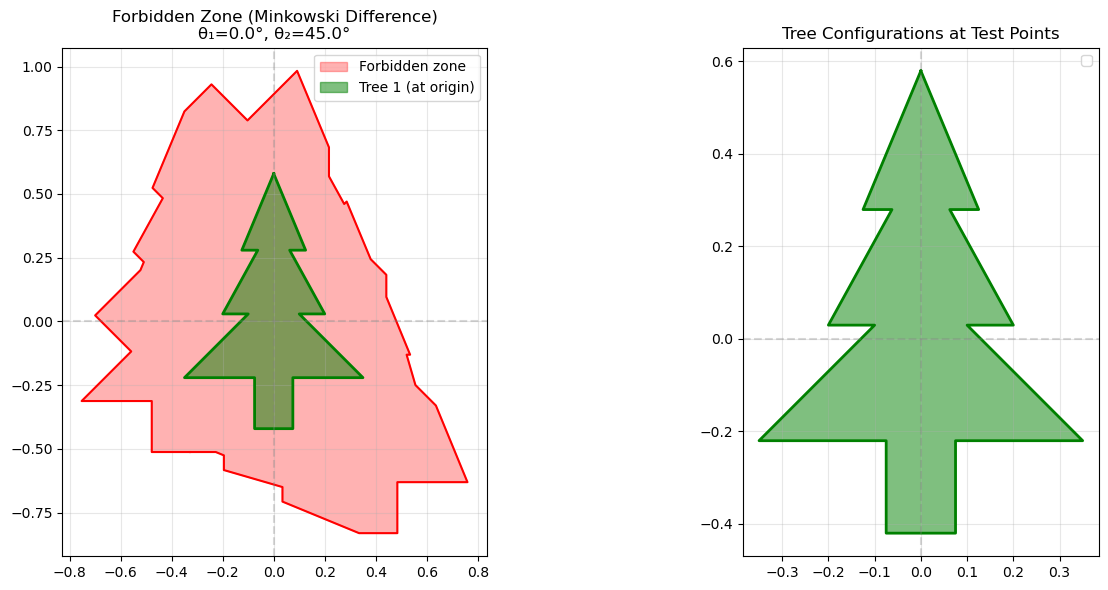

In [4]:
def plot_forbidden_zone_and_trees(forbidden_zone, tree1, tree2, theta1, theta2, test_points=None):
    """
    Visualize the forbidden zone (Minkowski difference) and test configurations.
    
    Parameters
    ----------
    forbidden_zone : Polygon
        The Minkowski difference (forbidden zone)
    tree1, tree2 : Polygon
        The tree polygons at their rotations
    theta1, theta2 : float
        Rotation angles
    test_points : list of (x, y, label, color), optional
        Points to test and visualize
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: Forbidden zone with test points
    ax = axes[0]
    ax.set_aspect('equal')
    ax.set_title(f'Forbidden Zone (Minkowski Difference)\nθ₁={np.degrees(theta1):.1f}°, θ₂={np.degrees(theta2):.1f}°')
    
    # Plot forbidden zone
    if isinstance(forbidden_zone, MultiPolygon):
        for geom in forbidden_zone.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
            ax.plot(x, y, 'r-', linewidth=1.5)
    else:
        x, y = forbidden_zone.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
        ax.plot(x, y, 'r-', linewidth=1.5)
    
    # Plot tree1 at origin
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green', label='Tree 1 (at origin)')
    ax.plot(x, y, 'g-', linewidth=2)
    
    # Plot test points
    if test_points:
        for px, py, label, color in test_points:
            ax.plot(px, py, 'o', markersize=10, color=color, label=label)
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Right plot: Actual tree configurations
    ax = axes[1]
    ax.set_aspect('equal')
    ax.set_title('Tree Configurations at Test Points')
    
    # Plot tree1 at origin
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green')
    ax.plot(x, y, 'g-', linewidth=2)
    
    # Plot tree2 at each test point
    if test_points:
        for px, py, label, color in test_points:
            tree2_translated = affinity.translate(tree2, xoff=px, yoff=py)
            x, y = tree2_translated.exterior.xy
            ax.fill(x, y, alpha=0.3, color=color)
            ax.plot(x, y, '-', linewidth=2, color=color, label=label)
            ax.plot(px, py, 'o', markersize=8, color=color)
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Basic visualization
fig = plot_forbidden_zone_and_trees(forbidden_zone, tree1, tree2, theta1, theta2)
plt.show()

## Accuracy Verification

We'll place trees at positions:
1. **Just inside** the Minkowski boundary (should overlap)
2. **Exactly on** the boundary (should just touch)
3. **Just outside** the boundary (should not overlap)

In [5]:
def verify_accuracy(theta2: float, test_angles: list = None):
    """
    Verify Minkowski difference accuracy by testing points inside/outside boundary.
    """
    theta1 = 0  # Tree 1 is always at rotation 0
    if test_angles is None:
        test_angles = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, np.pi]
    
    forbidden_zone, tree1, tree2 = mink.compute_forbidden_zone_with_trees(theta2)
    
    epsilon = 1e-4  # Small offset for inside/outside tests
    
    results = []
    
    for angle in test_angles:
        boundary_pt = mink.find_boundary_point(forbidden_zone, angle)
        if boundary_pt is None:
            continue
            
        bx, by = boundary_pt
        dist = np.sqrt(bx**2 + by**2)
        
        # Unit vector in this direction
        ux, uy = bx/dist, by/dist
        
        # Points just inside, on, and just outside boundary
        inside_pt = (bx - epsilon*ux, by - epsilon*uy)
        on_pt = (bx, by)
        outside_pt = (bx + epsilon*ux, by + epsilon*uy)
        
        # Check actual overlaps using Shapely
        for pt, pt_type in [(inside_pt, 'inside'), (on_pt, 'on'), (outside_pt, 'outside')]:
            tree2_at_pt = affinity.translate(tree2, xoff=pt[0], yoff=pt[1])
            intersection = tree1.intersection(tree2_at_pt)
            overlap_area = intersection.area
            
            # Check if point is inside forbidden zone
            pt_in_forbidden = forbidden_zone.contains(Point(pt))
            
            results.append({
                'angle_deg': np.degrees(angle),
                'position': pt_type,
                'x': pt[0],
                'y': pt[1],
                'in_forbidden_zone': pt_in_forbidden,
                'overlap_area': overlap_area,
                'overlaps': overlap_area > 1e-10
            })
    
    return results, forbidden_zone, tree1, tree2


# Run verification
theta1, theta2 = 0.0, np.pi/4
results, forbidden_zone, tree1, tree2 = verify_accuracy(theta2)

print(f"\nVerification Results (θ₁={np.degrees(theta1):.1f}°, θ₂={np.degrees(theta2):.1f}°):")
print("-" * 85)
print(f"{'Angle':>8} {'Position':>10} {'In Forbidden':>12} {'Overlaps':>10} {'Overlap Area':>15}")
print("-" * 85)
for r in results:
    status = '✓' if r['in_forbidden_zone'] == r['overlaps'] else '✗'
    print(f"{r['angle_deg']:>8.1f} {r['position']:>10} {str(r['in_forbidden_zone']):>12} {str(r['overlaps']):>10} {r['overlap_area']:>15.2e} {status}")


Verification Results (θ₁=0.0°, θ₂=45.0°):
-------------------------------------------------------------------------------------
   Angle   Position In Forbidden   Overlaps    Overlap Area
-------------------------------------------------------------------------------------
     0.0     inside         True       True        1.00e-06 ✓
     0.0         on         True      False        0.00e+00 ✗
     0.0    outside        False      False        0.00e+00 ✓
    30.0     inside         True       True        4.66e-09 ✓
    30.0         on        False      False        0.00e+00 ✓
    30.0    outside        False      False        0.00e+00 ✓
    45.0     inside         True       True        1.00e-06 ✓
    45.0         on        False      False        0.00e+00 ✓
    45.0    outside        False      False        0.00e+00 ✓
    60.0     inside         True       True        5.59e-09 ✓
    60.0         on         True      False        7.70e-34 ✗
    60.0    outside        False      False

0.7853981633974483


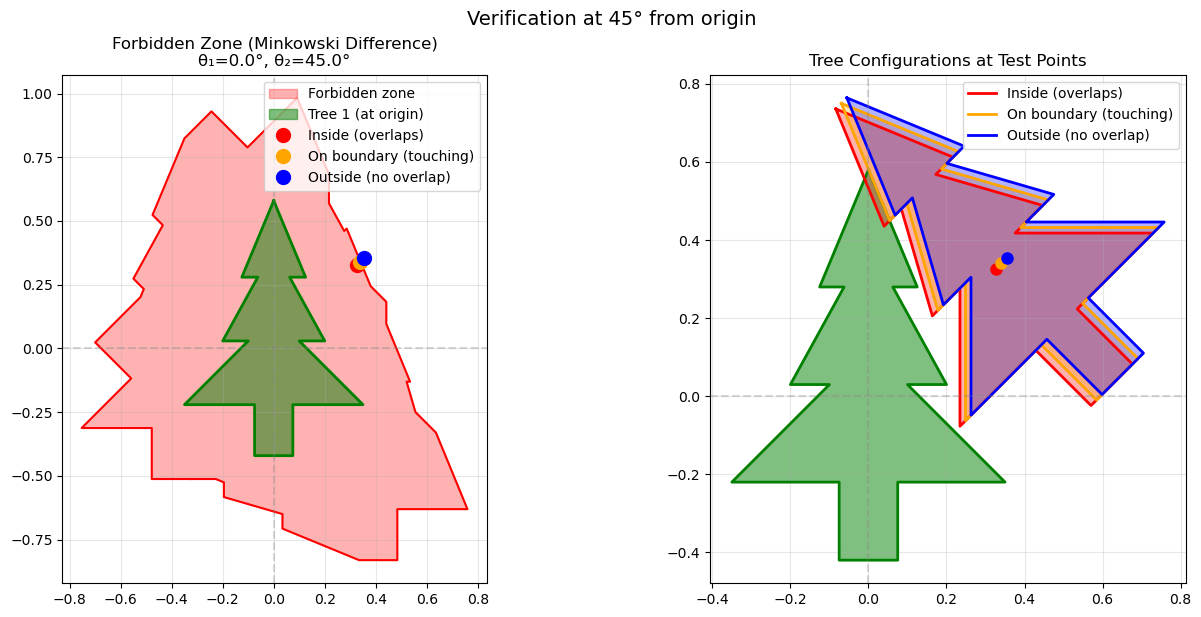


Actual overlap verification:
  Inside (overlaps): overlap area = 0.002470
  On boundary (touching): overlap area = 0.000000
  Outside (no overlap): overlap area = 0.000000


In [6]:
# Visualize specific test cases
test_angle = np.pi / 4  # 45 degrees

boundary_pt = mink.find_boundary_point(forbidden_zone, test_angle)
bx, by = boundary_pt
dist = np.sqrt(bx**2 + by**2)
ux, uy = bx/dist, by/dist

epsilon = 0.02  # Larger epsilon for visibility

test_points = [
    (bx - epsilon*ux, by - epsilon*uy, 'Inside (overlaps)', 'red'),
    (bx, by, 'On boundary (touching)', 'orange'),
    (bx + epsilon*ux, by + epsilon*uy, 'Outside (no overlap)', 'blue'),
]
print(theta2)
fig = plot_forbidden_zone_and_trees(forbidden_zone, tree1, tree2, theta1, theta2, test_points)
plt.suptitle(f'Verification at {np.degrees(test_angle):.0f}° from origin', fontsize=14, y=1.02)
plt.show()

# Check actual overlaps
print("\nActual overlap verification:")
for px, py, label, color in test_points:
    tree2_at_pt = affinity.translate(tree2, xoff=px, yoff=py)
    overlap = tree1.intersection(tree2_at_pt)
    print(f"  {label}: overlap area = {overlap.area:.6f}")

## Test with Different Rotations

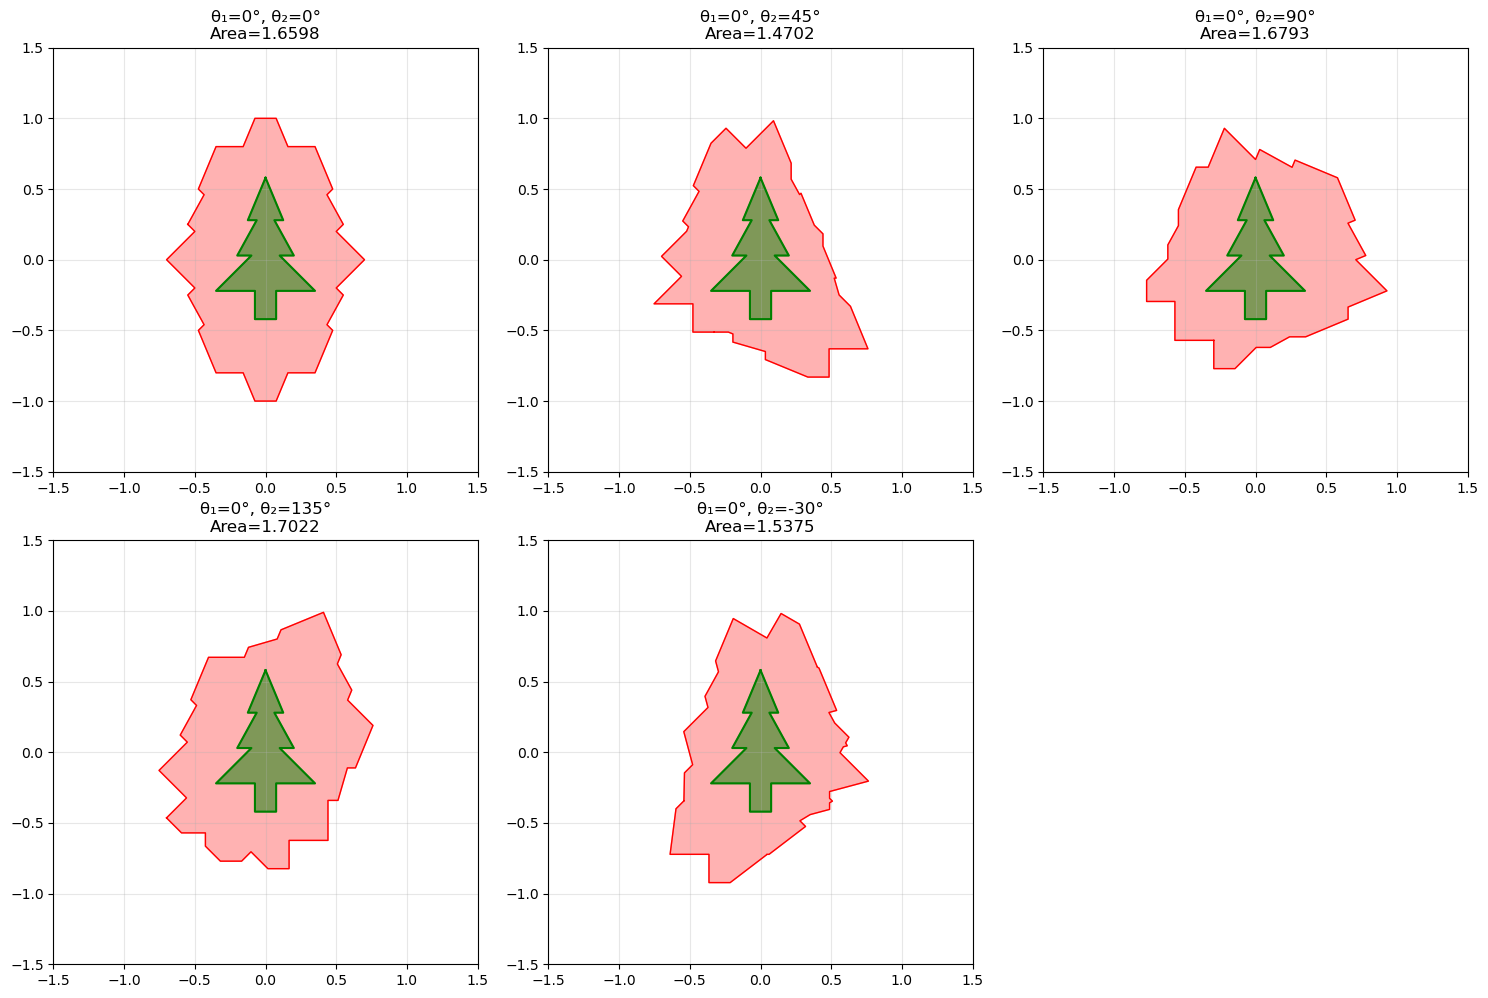

In [7]:
# Test with various rotation combinations (tree1 is always at rotation 0)
rotation_pairs = [
    (0.0, 0.0),
    (0.0, np.pi/4),
    (0.0, np.pi/2),
    (0.0, 3*np.pi/4),
    (0.0, -np.pi/6),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (t1, t2) in enumerate(rotation_pairs):
    ax = axes[idx]
    forbidden_zone, tree1, tree2 = mink.compute_forbidden_zone_with_trees(t2)
    
    ax.set_aspect('equal')
    ax.set_title(f'θ₁={np.degrees(t1):.0f}°, θ₂={np.degrees(t2):.0f}°\nArea={forbidden_zone.area:.4f}')
    
    # Plot forbidden zone
    if isinstance(forbidden_zone, MultiPolygon):
        for geom in forbidden_zone.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red')
            ax.plot(x, y, 'r-', linewidth=1)
    else:
        x, y = forbidden_zone.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red')
        ax.plot(x, y, 'r-', linewidth=1)
    
    # Plot tree at origin
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green')
    ax.plot(x, y, 'g-', linewidth=1.5)
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.grid(True, alpha=0.3)

# Hide last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Separation Distance Function

The separation distance (penetration depth) is the minimum translation needed to separate overlapping trees.

In [8]:
# Reload module to get vectorized separation_distance
importlib.reload(mink)

# Test the vectorized separation_distance function

# Single point test (backward compatible)
tree1_pos = (0, 0)
tree2_pos = np.array([0.5, 0])
sep_dist = mink.separation_distance(tree1_pos, tree2_pos, 0.0)
print(f"Single point test: sep_dist = {sep_dist:+.6f}")

# Vectorized test with multiple positions
tree2_positions = np.array([
    [0.5, 0.0],    # Close, overlapping
    [1.0, 0.0],    # On boundary or just outside
    [1.5, 0.0],    # Separated
    [0.3, 0.3],    # Diagonal
    [0.0, 0.8],    # Vertical
    [-0.5, 0.0],   # Left side
])

print("\nVectorized Separation Distance Tests (theta2=0):")
print("-" * 60)
sep_distances = mink.separation_distance((0, 0), tree2_positions, 0.0)
for i, (pos, dist) in enumerate(zip(tree2_positions, sep_distances)):
    status = "OVERLAPPING" if dist > 0 else "SEPARATED"
    print(f"  Position {pos}: sep_dist = {dist:+.6f} ({status})")

# Test with rotation
print("\nVectorized test with theta2=45°:")
sep_distances_rot = mink.separation_distance((0, 0), tree2_positions, np.pi/4)
for i, (pos, dist) in enumerate(zip(tree2_positions, sep_distances_rot)):
    status = "OVERLAPPING" if dist > 0 else "SEPARATED"
    print(f"  Position {pos}: sep_dist = {dist:+.6f} ({status})")

Single point test: sep_dist = +0.141448

Vectorized Separation Distance Tests (theta2=0):
------------------------------------------------------------
  Position [0.5 0. ]: sep_dist = +0.141448 (OVERLAPPING)
  Position [1. 0.]: sep_dist = -0.299960 (SEPARATED)
  Position [1.5 0. ]: sep_dist = -0.799960 (SEPARATED)
  Position [0.3 0.3]: sep_dist = +0.194992 (OVERLAPPING)
  Position [0.  0.8]: sep_dist = +0.146176 (OVERLAPPING)
  Position [-0.5  0. ]: sep_dist = +0.141448 (OVERLAPPING)

Vectorized test with theta2=45°:
  Position [0.5 0. ]: sep_dist = -0.017350 (SEPARATED)
  Position [1. 0.]: sep_dist = -0.483028 (SEPARATED)
  Position [1.5 0. ]: sep_dist = -0.924345 (SEPARATED)
  Position [0.3 0.3]: sep_dist = +0.052682 (OVERLAPPING)
  Position [0.  0.8]: sep_dist = +0.064571 (OVERLAPPING)
  Position [-0.5  0. ]: sep_dist = +0.124811 (OVERLAPPING)


Computed 10000 separation distances in 0.071s (140253 pts/sec)


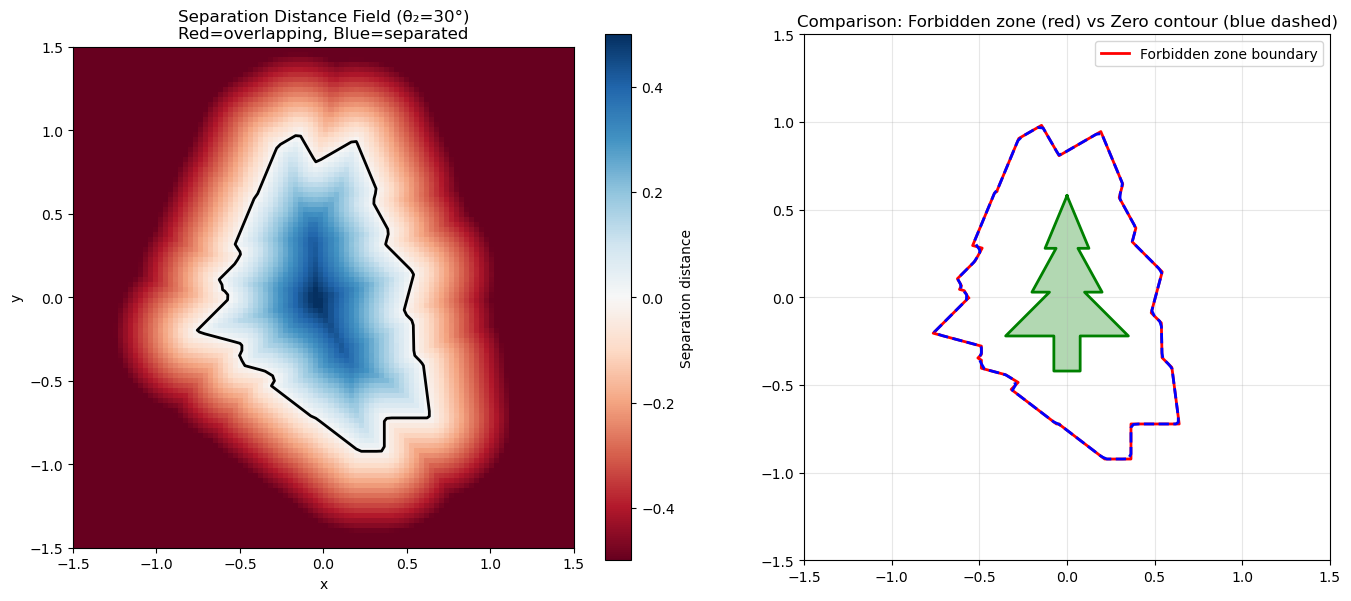

In [9]:
# Visualize separation distance field using vectorized computation
import time

theta2 = np.pi / 6  # 30 degrees

# Create a grid of points
resolution = 100
x_range = np.linspace(-1.5, 1.5, resolution)
y_range = np.linspace(-1.5, 1.5, resolution)
xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# Compute separation distances for all grid points at once
start = time.time()
sep_dists = mink.separation_distance((0, 0), grid_points, theta2)
elapsed = time.time() - start
print(f"Computed {len(grid_points)} separation distances in {elapsed:.3f}s ({len(grid_points)/elapsed:.0f} pts/sec)")

# Reshape for plotting
sep_field = sep_dists.reshape(resolution, resolution)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Separation distance field
ax = axes[0]
im = ax.imshow(sep_field, extent=[-1.5, 1.5, -1.5, 1.5], origin='lower', 
               cmap='RdBu', vmin=-0.5, vmax=0.5)
ax.contour(xx, yy, sep_field, levels=[0], colors='black', linewidths=2)
plt.colorbar(im, ax=ax, label='Separation distance')
ax.set_title(f'Separation Distance Field (θ₂={np.degrees(theta2):.0f}°)\nRed=overlapping, Blue=separated')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')

# Right: Overlay with forbidden zone
ax = axes[1]
forbidden_zone, tree1, tree2 = mink.compute_forbidden_zone_with_trees(theta2)

# Plot forbidden zone boundary
if isinstance(forbidden_zone, MultiPolygon):
    for geom in forbidden_zone.geoms:
        x, y = geom.exterior.xy
        ax.plot(x, y, 'r-', linewidth=2, label='Forbidden zone boundary')
else:
    x, y = forbidden_zone.exterior.xy
    ax.plot(x, y, 'r-', linewidth=2, label='Forbidden zone boundary')

# Plot zero contour from separation distance
ax.contour(xx, yy, sep_field, levels=[0], colors='blue', linewidths=2, linestyles='--')

# Plot tree1
x, y = tree1.exterior.xy
ax.fill(x, y, alpha=0.3, color='green')
ax.plot(x, y, 'g-', linewidth=2)

ax.set_title('Comparison: Forbidden zone (red) vs Zero contour (blue dashed)')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Interactive Visualization

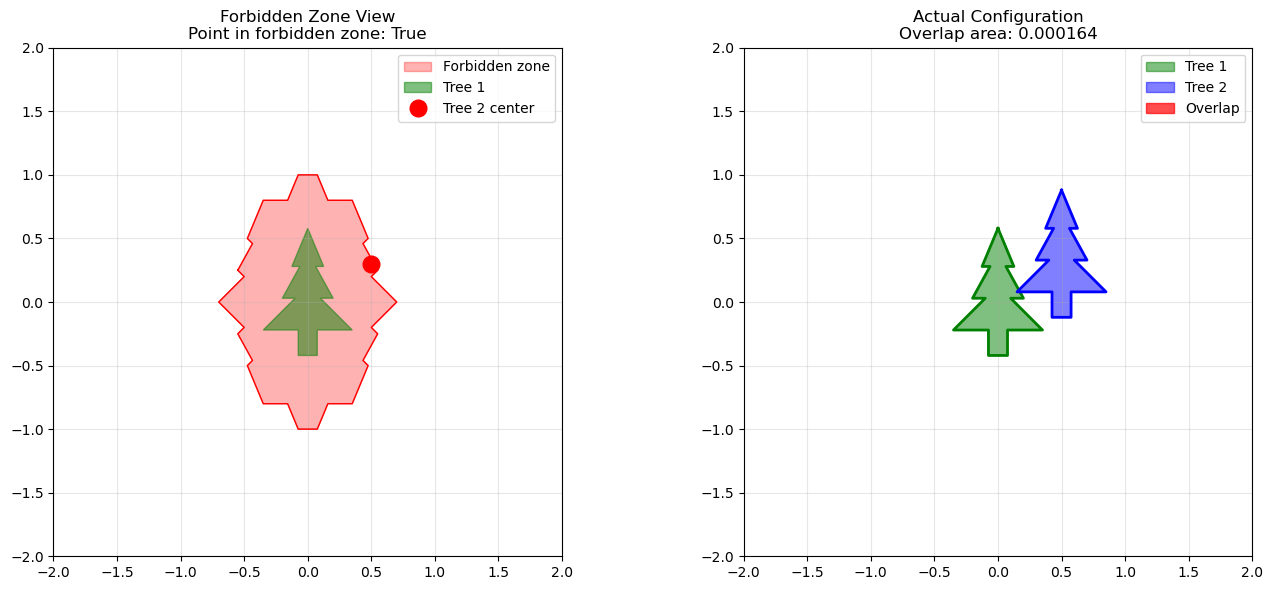

In forbidden zone: True
Actually overlaps: True
Consistent: ✓


True

In [10]:
def interactive_test(theta2_deg, dx, dy):
    """
    Interactive test: visualize tree configuration and verify against forbidden zone.
    Tree1 is always at rotation 0.
    """
    theta1 = 0  # Always 0
    theta2 = np.radians(theta2_deg)
    
    forbidden_zone, tree1, tree2 = mink.compute_forbidden_zone_with_trees(theta2)
    
    # Check overlap
    tree2_translated = affinity.translate(tree2, xoff=dx, yoff=dy)
    actual_overlap = tree1.intersection(tree2_translated)
    
    # Check if in forbidden zone
    in_forbidden = forbidden_zone.contains(Point(dx, dy))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Forbidden zone view
    ax = axes[0]
    ax.set_aspect('equal')
    
    if isinstance(forbidden_zone, MultiPolygon):
        for geom in forbidden_zone.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red')
            ax.plot(x, y, 'r-', linewidth=1)
    else:
        x, y = forbidden_zone.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
        ax.plot(x, y, 'r-', linewidth=1)
    
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green', label='Tree 1')
    
    color = 'red' if in_forbidden else 'blue'
    ax.plot(dx, dy, 'o', markersize=12, color=color, label=f'Tree 2 center')
    
    ax.set_title(f'Forbidden Zone View\nPoint in forbidden zone: {in_forbidden}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    # Right: Actual tree configuration
    ax = axes[1]
    ax.set_aspect('equal')
    
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green', label='Tree 1')
    ax.plot(x, y, 'g-', linewidth=2)
    
    x, y = tree2_translated.exterior.xy
    ax.fill(x, y, alpha=0.5, color='blue', label='Tree 2')
    ax.plot(x, y, 'b-', linewidth=2)
    
    # Highlight overlap
    if not actual_overlap.is_empty and actual_overlap.area > 0:
        if isinstance(actual_overlap, MultiPolygon):
            for geom in actual_overlap.geoms:
                x, y = geom.exterior.xy
                ax.fill(x, y, alpha=0.7, color='red')
        elif hasattr(actual_overlap, 'exterior'):
            x, y = actual_overlap.exterior.xy
            ax.fill(x, y, alpha=0.7, color='red', label='Overlap')
    
    ax.set_title(f'Actual Configuration\nOverlap area: {actual_overlap.area:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    plt.tight_layout()
    plt.show()
    
    # Verify consistency
    overlaps = actual_overlap.area > 1e-10
    consistent = in_forbidden == overlaps
    print(f"In forbidden zone: {in_forbidden}")
    print(f"Actually overlaps: {overlaps}")
    print(f"Consistent: {'✓' if consistent else '✗ MISMATCH!'}")
    
    return consistent


# Test cases (theta1 is always 0)
interactive_test(0, 0.5, 0.3)  # Should overlap

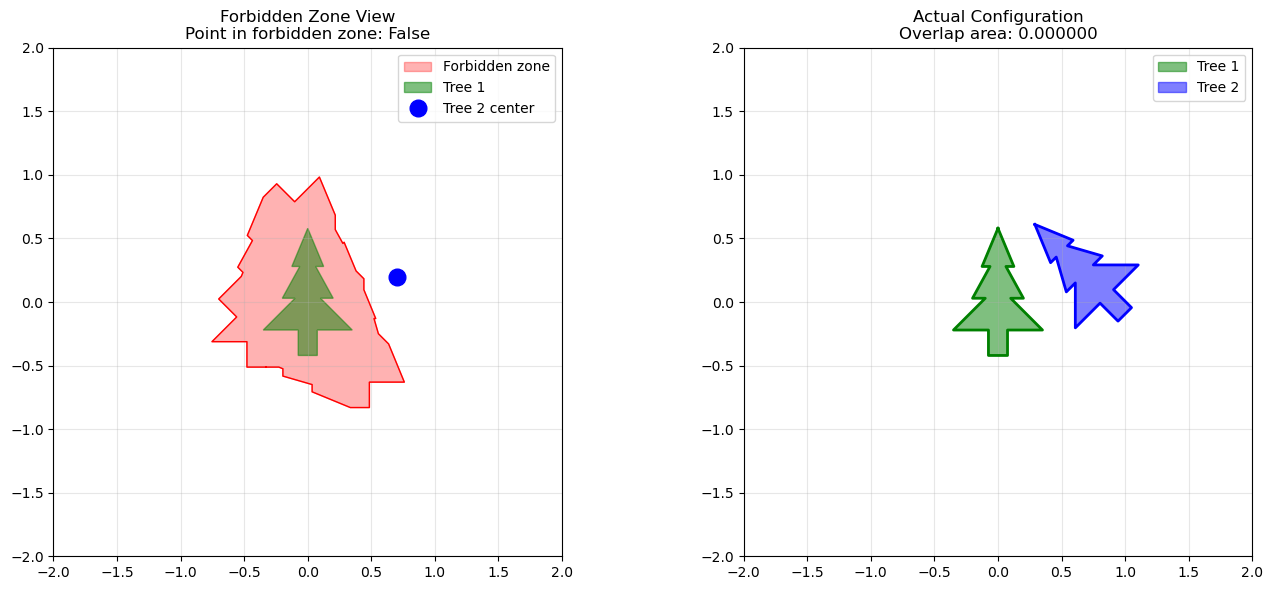

In forbidden zone: False
Actually overlaps: False
Consistent: ✓


True

In [11]:
interactive_test(45, 0.7, 0.2)  # With rotation

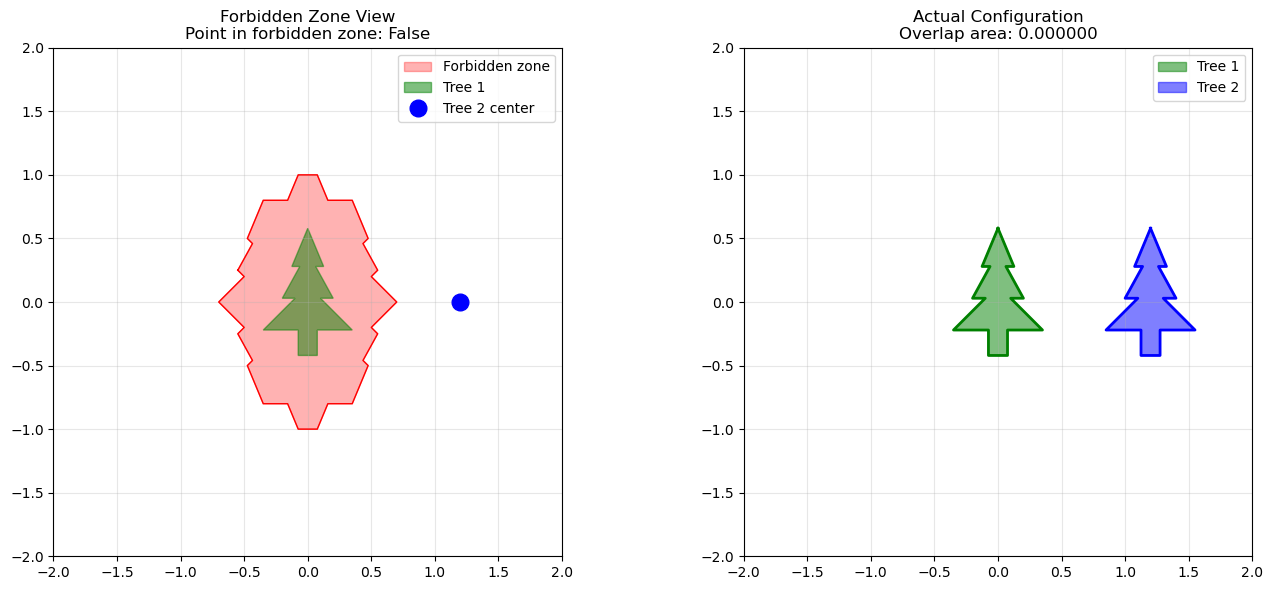

In forbidden zone: False
Actually overlaps: False
Consistent: ✓


True

In [12]:
interactive_test(0, 1.2, 0.0)  # Should not overlap

## Summary

The **Minkowski difference** approach provides **exact** separation distance computation:

1. **Minkowski Difference M(A, -B) = A ⊖ B** represents all positions where B's center would cause overlap with A
2. For non-convex polygons, we use **convex decomposition** and union of pairwise differences
3. **Separation distance** = signed distance from relative position to Minkowski boundary
   - Positive: penetration depth (trees overlap)
   - Negative: clearance (trees don't overlap)

This is suitable for building a lookup table since:
- Tree 1 is always at rotation 0 (never rotated)
- The computation depends only on (θ₂, dx, dy)
- The Minkowski difference only needs to be computed once per θ₂ value

The logic is now in the `pack_minkowski` module.